In [1]:
import casadi as ca
import sys
sys.path.insert(0, '../python/pyecca')

import matplotlib.pyplot as plt
from pyecca.util import rk4
import numpy as np

from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())


In [6]:
def numerical(x_end, n_x):
    """
    Edit this function and setup an optimal control problem that minimizes the time
    it takes for a ball rolling a long a curve to reach the end of the path assuming it
    starts at a height of 1 m and ends at a height of 0 m and the length of the path is
    x_end m.
    """
    x_pos = np.linspace(0, x_end, n_x)  # x position where path changes
#     dx = x[1] - x[0]  # path steps width
#     n_dy = n_x - 1  # number of height changes we need to find
#     dy0 = -(1/n_dy)*np.ones(n_dy)  # initial guess for height change along path
    
    x_1 = x_pos[0]
    x_2 = x_pos[-1]
    y_1 = 1
    y_2 = 0
    
    y_pos_guess = np.concatenate((np.linspace(1,-0.3,n_x/2),np.linspace(-0.3+0.01,0,n_x/2)),axis=0)
    #y_pos_guess = np.linspace(0.1,0,n_x)    
    y_pos = ca.SX.sym('y_pos',n_x)
        
    nlp = {'x': y_pos, 'f': t12(x_pos,y_pos), 'g': ca.vertcat(y_pos[0]-y_1,y_pos[-1]-y_2)}
    tmin = ca.nlpsol('tmin', 'ipopt', nlp, {
    'print_time': 0,
    'ipopt': {
        'sb': 'yes',
        'print_level': 0,
        }
    })
    res = tmin(x0=y_pos_guess,ubx=1,lbx =-10, lbg=(0,0),ubg=(0,0))
    y_opt = res['x']


    
#     dy_opt = dy0 # TODO, find optimal change in y along path
#     y_opt = ca.vertcat(1, 1 + np.cumsum(dy_opt))
    return x_pos, y_opt

# def t12(x_pos,y_pos):
#     g = 9.81
#     y_dists = ca.diff(y_pos)
#     x_dists = ca.diff(x_pos)
#     dists = ca.sqrt(ca.power(y_dists,2)+ca.power(x_dists,2))
    
#     unsigned_deltaVtots = ca.sqrt(2*g*y_dists/ca.sign(y_dists))/2
#     deltaVtots = ca.if_else(y_dists>0, -1*unsigned_deltaVtots, unsigned_deltaVtots)
# #     delta_Vxs = deltaVtots*x_dists/dists
#     delta_Vys = deltaVtots*y_dists/dists
#     Vys = ca.cumsum(delta_Vys)
#     ts = y_dists/Vys
#     t_total = ca.sum1(ts)

    
#     return t_total

def t12(x_pos,y_pos):
    g = 9.81
    y_dists = ca.diff(y_pos)
    x_dists = ca.diff(x_pos)
    dists = ca.sqrt(ca.power(y_dists,2)+ca.power(x_dists,2))
    
    unsigned_deltaVtots = ca.sqrt(2*g*y_dists*ca.sign(y_dists))/2
    deltaVtots = ca.if_else(y_dists>0, -1*unsigned_deltaVtots, unsigned_deltaVtots)
#     delta_Vxs = deltaVtots*x_dists/dists
#     delta_Vys = deltaVtots*y_dists/dists
    Vtots = ca.cumsum(deltaVtots)
    ts = dists/Vtots
    t_total = ca.sum1(ts)
    
    return t_total

# def t12(x_pos,y_pos):
#     g = 9.81
#     y_dists = ca.diff(y_pos)
#     x_dists = ca.diff(x_pos)
#     dists = ca.sqrt(ca.power(y_dists,2)+ca.power(x_dists,2))
    
#     unsigned_deltaVtots = ca.sqrt(2*g*y_dists*ca.sign(y_dists))/2
#     deltaVtots = ca.if_else(y_dists>0, -1*unsigned_deltaVtots, unsigned_deltaVtots)
# #     delta_Vxs = deltaVtots*x_dists/dists
# #     delta_Vys = deltaVtots*y_dists/dists
#     Vys = ca.cumsum(deltaVtots)*y_dists/dists
#     ts = y_dists/Vys
#     t_total = ca.sum1(ts)
    
#     return t_total

# def t12(x_pos,y_pos):
#     g = 9.81
#     Vtots = ca.sqrt(2*g*(y_pos[0]-y_pos))
#     Vavgs = ca.diff(Vtots)/2
#     ts = y_dists/Vys/
#     t_total = ca.sum1(ts)

    
#     return t_total

def getTs(x_pos,y_pos):
    g = 9.81
    y_dists = ca.diff(y_pos)
    x_dists = ca.diff(x_pos)
    dists = ca.sqrt(ca.power(y_dists,2)+ca.power(x_dists,2))
    
    unsigned_deltaVtots = ca.sqrt(2*g*y_dists/ca.sign(y_dists))/2
    deltaVtots = ca.if_else(y_dists>0, -1*unsigned_deltaVtots, unsigned_deltaVtots)
#     delta_Vxs = deltaVtots*x_dists/dists
    delta_Vys = deltaVtots*y_dists/dists
    Vys = ca.cumsum(delta_Vys)
    ts = y_dists/Vys
    
    return ts

In [7]:
# NLP declaration to solve for boundary condition of brachistochrone
def analytical(x_end, n_x):
    c = ca.SX.sym('c')
    theta_f = ca.SX.sym('theta_f')
    xf = c*(theta_f - np.sin(theta_f))
    yf = 1 - c*(1 - np.cos(theta_f))

    nlp = {'x':ca.vertcat(c, theta_f), 'f':0,'g':ca.vertcat(xf-x_end,yf)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    res = S(x0=(1, np.pi), lbg=(0, 0), ubg=(0, 0))
    C_opt = float(res['x'][0])
    theta_f_opt = float(res['x'][1])
    theta = np.linspace(0, theta_f_opt, n_x)
    xa = C_opt*(theta - np.sin(theta))
    ya = 1 - C_opt*(1 - np.cos(theta))
    return xa, ya

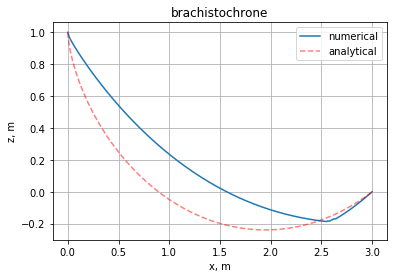

In [14]:
n_x = 200  # number of points for approximation of path
x_end = 3  # final x position when height is zero

# analytical solution
xa, ya = analytical(x_end=x_end, n_x=n_x)

# numerical solution
x, y_opt = numerical(x_end=x_end, n_x=n_x)

# plot
plt.title('brachistochrone')
plt.plot(x, y_opt, label='numerical')
plt.plot(xa, ya, 'r--', label='analytical', alpha=0.5)
plt.grid(True)
plt.xlabel('x, m')
plt.ylabel('z, m')
plt.legend()